# Import

In [1]:
from scipy.stats import gaussian_kde
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import expanduser
import sys
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import joblib
import pickle
import csv

home = expanduser("~")

# data

In [2]:
filename='featuresXeM'
data_file_name=filename+".csv" # diversity selection filename

 
diverse_ratio=0.8 # training set ratio, 
remaining_ratio=1-diverse_ratio # test set ratio

In [30]:
diverse_set=[]
remaining_set=[]

txt = open("divided_set_"+str(diverse_ratio)+"_"+str("%.1f"%remaining_ratio)+"_"+"Xe-M.txt",'r').read()
print(" Load file name : divided_set_"+str(diverse_ratio)+"_"+str("%.1f"%remaining_ratio)+"_"+"Xe-M.txt")
s1=txt.find("[",0)
s2=txt.find("]",s1)
diverse_set=txt[s1+1:s2].split(", ")
diverse_set=[int(i) for i in diverse_set]
s3=txt.find("[",s2)
s4=txt.find("]",s3)
remaining_set=txt[s3+1:s4].split(", ")
remaining_set=[int(i) for i in remaining_set]
print("# of diverse set, remaining set :",len(diverse_set),len(remaining_set))


with open(data_file_name) as f:
        data_file = csv.reader(f)
        temp = next(data_file)
        N_samples = int(temp[0])
        N_features = int(temp[1])
        N_targets = int(temp[2])
        number = np.empty((N_samples,))
        structure = np.empty((N_samples,))
        data = np.empty((N_samples, N_features))
        target = np.empty((N_samples,N_targets))
        temp = next(data_file)  # names of features
        structure = []
        feature_names=temp[2:2+N_features]
        for i, d in enumerate(data_file):
            number[i] = np.asarray(d[0],dtype=np.int)
            structure.append(d[1])
            data[i] = np.asarray(d[2:2+N_features], dtype=np.float64)
            target[i] = np.asarray(d[-N_targets:], dtype=np.float64)
N_materials = data.shape[0]

diverse_set_total=[]
remaining_set_total=[]
for i,diverse in enumerate(diverse_set):
    arridx = np.where(number == diverse)
    for j,element_div in enumerate(arridx[0]):
        diverse_set_total.append(element_div)
for i,remaining in enumerate(remaining_set):
    arridx = np.where(number == remaining)
    for j,element_rem in enumerate(arridx[0]):
        remaining_set_total.append(element_rem)        

X_train = data[diverse_set_total]
y_train = target[diverse_set_total]
X_test = data[remaining_set_total]
y_test = target[remaining_set_total]

 Load file name : divided_set_0.8_0.2_Xe-M.txt
# of diverse set, remaining set : 994 249


<ipython-input-30-dd663689e4d9>:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  number[i] = np.asarray(d[0],dtype=np.int)


# Find Train and Test

In [31]:
df_Train_Inputs = pd.DataFrame(X_train, columns = ["PLD","LCD","Density","ASA_m2/cm3","AV_VF","Xe_heat"])
df_Test_Inputs = pd.DataFrame(X_test, columns = ["PLD","LCD","Density","ASA_m2/cm3","AV_VF","Xe_heat"])

df_Train_Target = pd.DataFrame(y_train, columns = ["Xe_M"])
df_Test_Target = pd.DataFrame(y_test, columns = ["Xe_M"])

In [32]:
df_Train = pd.concat([df_Train_Inputs,df_Train_Target],axis=1)
df_Test = pd.concat([df_Test_Inputs,df_Test_Target],axis=1)

In [33]:
df_Train.to_csv('Train'+'_Xe'+'.csv', header=True, index=False)
df_Test.to_csv('Test'+'_Xe'+'.csv', header=True, index=False)

# Load

In [34]:
reg_opt= joblib.load("GBR"+"_Xe_M_Langmuir.pkl") 
print(reg_opt)
print('R^2 Training Score: {:.5f} \nR^2 Testing Score: {:.5f}'.format(reg_opt.score(X_train, y_train),reg_opt.score(X_test, y_test)))
print('RMSE Training Score: {:.3f} \nRMSE Testing Score: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,reg_opt.predict(X_train))),np.sqrt(mean_squared_error(y_test,reg_opt.predict(X_test)))))
print('MAE Training Score: {:.3f} \nMAE Testing Score: {:.3f}'.format(mean_absolute_error(y_train,reg_opt.predict(X_train)),mean_absolute_error(y_test,reg_opt.predict(X_test))))
print([feature+" : "+str(reg_opt.feature_importances_[i]) for i,feature in enumerate(feature_names)])

XGBRegressor(alpha=0.019183749921977387, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0.001, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.18800395774002038,
             max_delta_step=0, max_depth=42, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=446, n_jobs=16,
             num_parallel_tree=31, random_state=0, reg_alpha=0.0191837493,
             reg_lambda=1, scale_pos_weight=1, subsample=0.27494562012538826,
             tree_method='exact', validate_parameters=1, verbosity=None)
R^2 Training Score: 0.99989 
R^2 Testing Score: 0.96040
RMSE Training Score: 0.226 
RMSE Testing Score: 0.753
MAE Training Score: 0.027 
MAE Testing Score: 0.537
['PLD : 0.05914881', 'LCD : 0.034556314', 'Density : 0.55262065', 'ASA_m2_cm3 : 0.0028326828', 'AV_VF : 0.1259806', 'Xe_heat : 0.22486094']


# Predict

In [35]:
data_Train=pd.read_csv("Train_Xe.csv",header=0)
data_Test=pd.read_csv("Test_Xe.csv",header=0)

X_Train = pd.DataFrame(data_Train, columns = ["PLD","LCD","Density","ASA_m2/cm3","AV_VF","Xe_heat"])
y_Train = reg_opt.predict(X_Train.values)

X_Test = pd.DataFrame(data_Test, columns = ["PLD","LCD","Density","ASA_m2/cm3","AV_VF","Xe_heat"])
y_Test = reg_opt.predict(X_Test.values)

df_Train_pre = pd.concat([data_Train,pd.DataFrame(y_Train, columns = ["Xe_M_pre"])],axis=1)
df_Test_pre = pd.concat([data_Test,pd.DataFrame(y_Test, columns = ["Xe_M_pre"])],axis=1)

df_Train_pre.to_csv('Train'+'_Xe'+'.csv', header=True, index=False)
df_Test_pre.to_csv('Test'+'_Xe'+'.csv', header=True, index=False)

# Draw

In [2]:
data1=pd.read_csv('Train'+'_Xe'+'.csv')
data2=pd.read_csv('Test'+'_Xe'+'.csv')

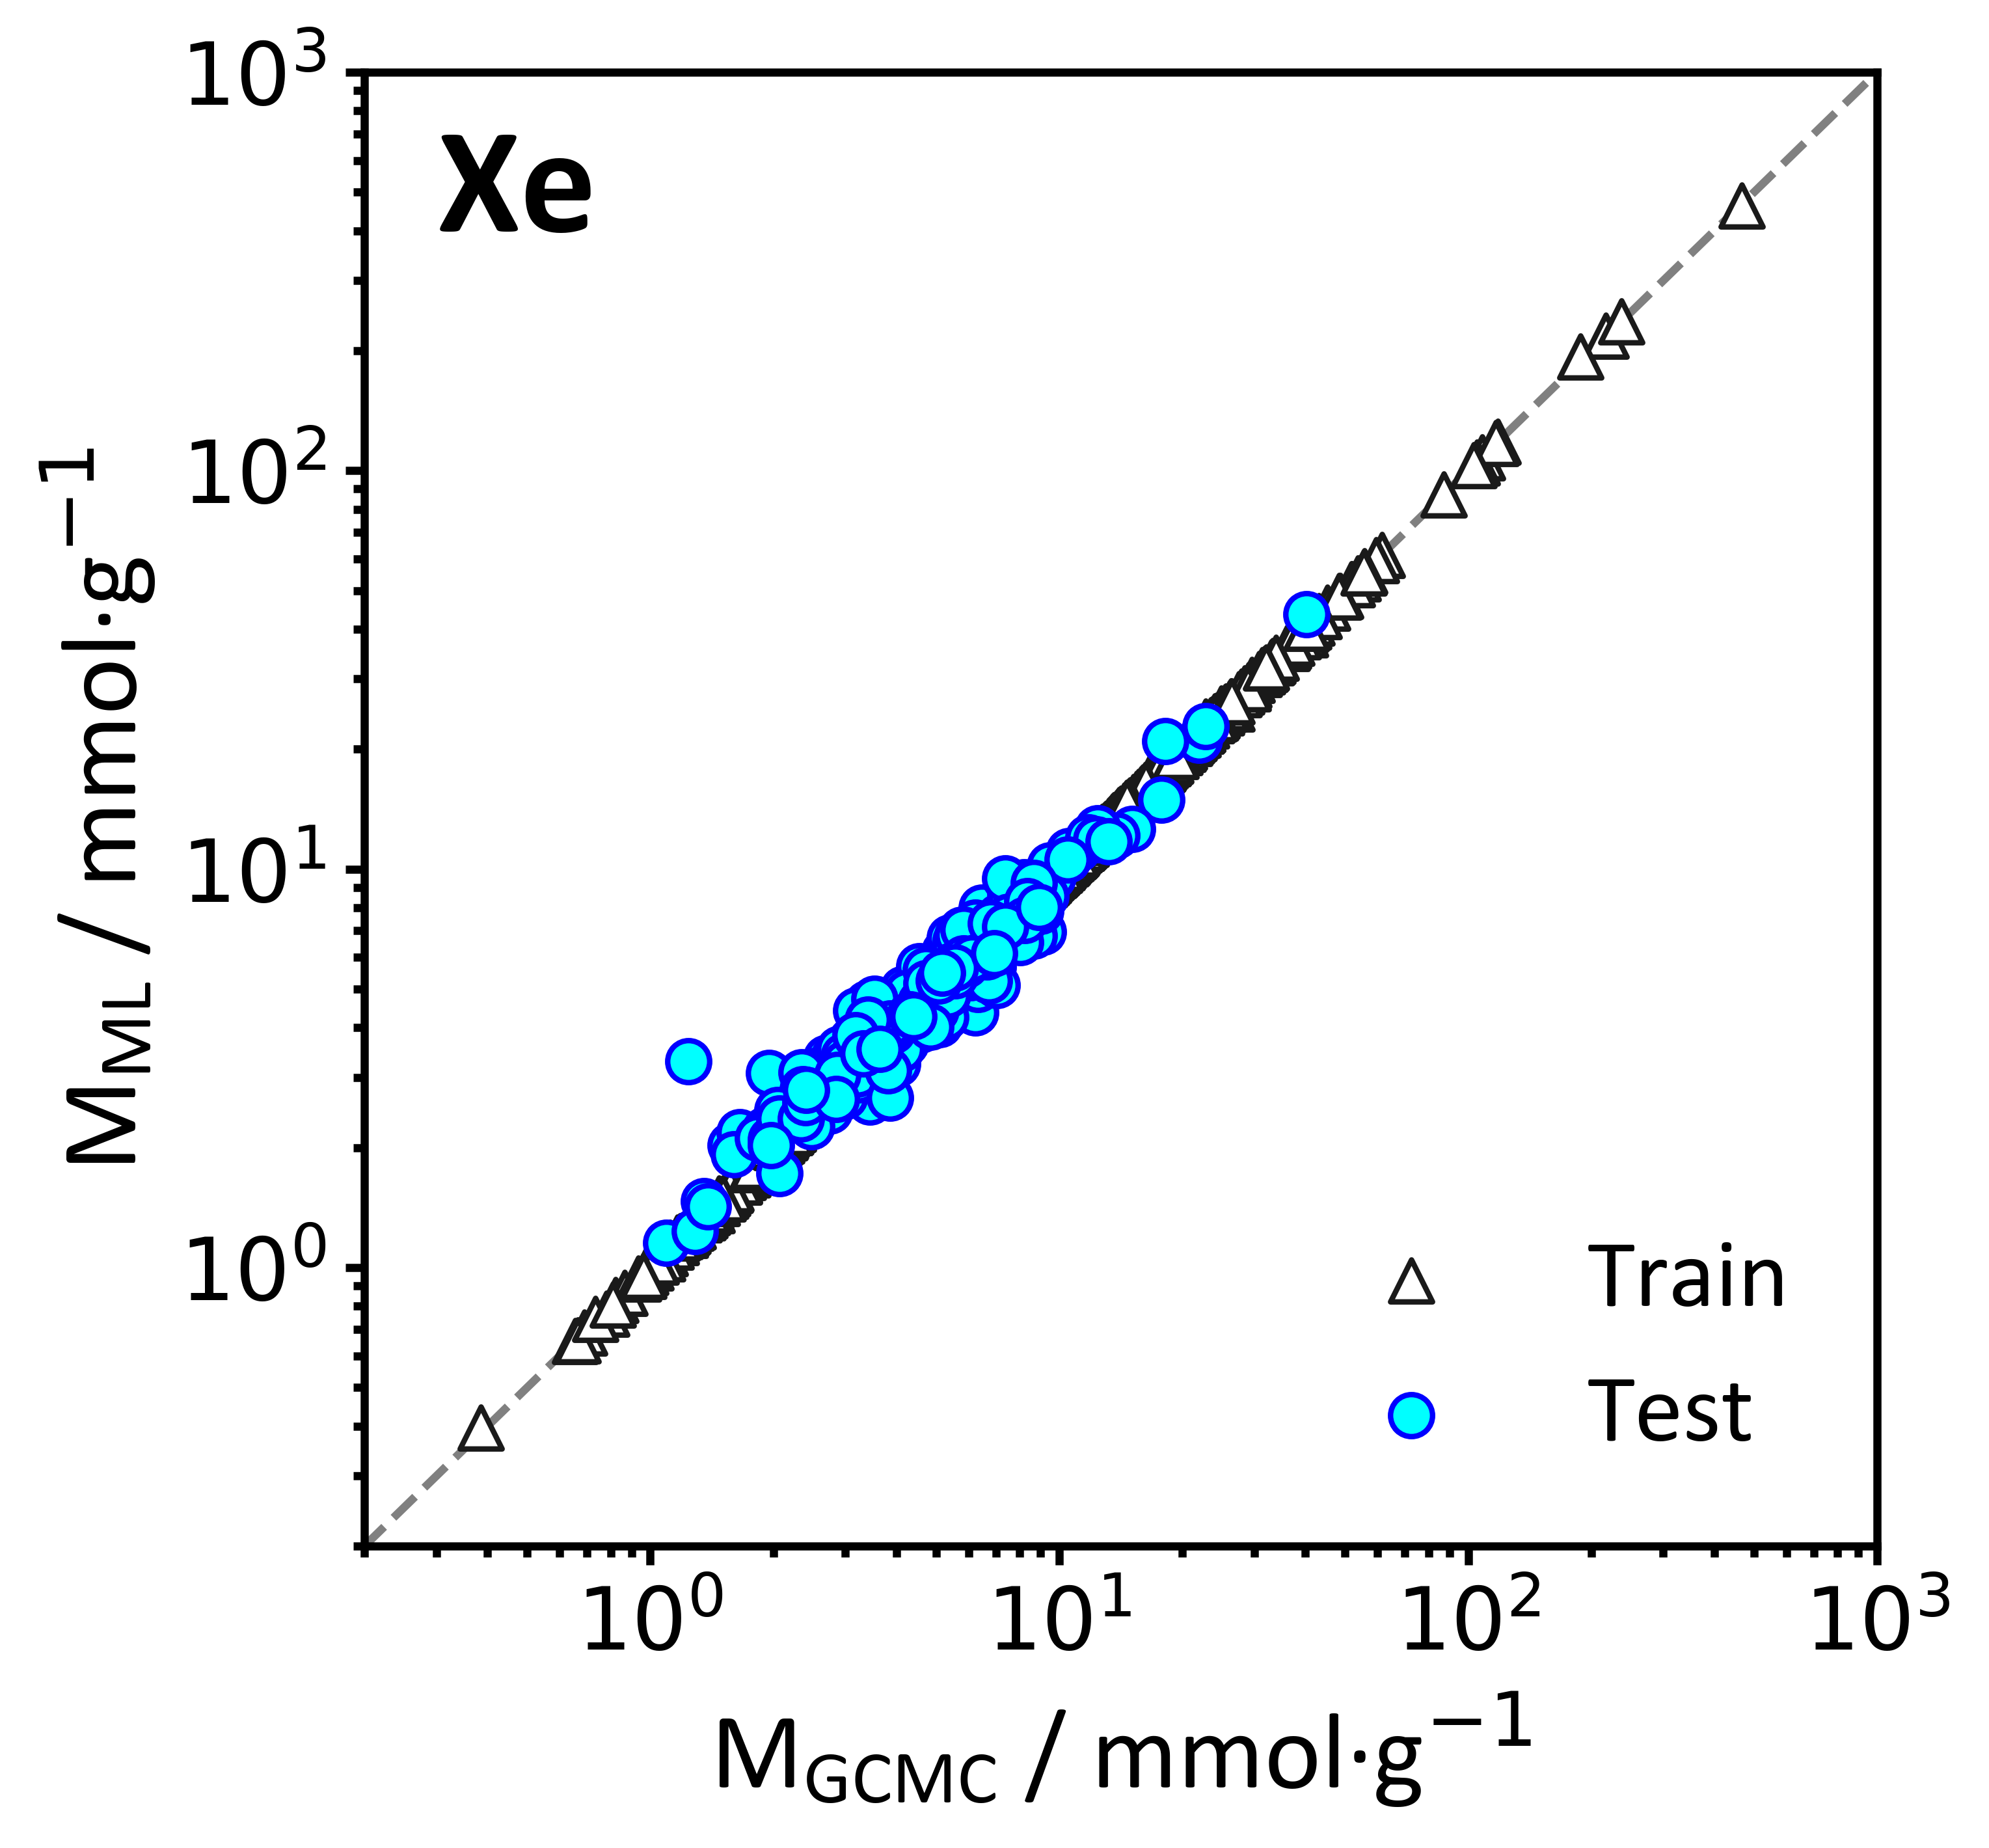

In [3]:
fig, ax = plt.subplots(figsize=(5,5),dpi=600)
ax.set_xscale('log')
ax.set_yscale('log')

x=np.linspace(0,1000)

ax.plot(x,x,'--',c="0.5",zorder=0)

ax1 = ax.scatter(data1["Xe_M"],data1["Xe_M_pre"],marker='^',c="w",edgecolor='0.1',s=60,label="Train",linewidths=1)
ax2 = ax.scatter(data2["Xe_M"],data2["Xe_M_pre"],marker='o',c="cyan",edgecolor='b',s=60,label="Test",linewidths=1)

ax.set_xlim(0.2 ,1000)
ax.set_ylim(0.2 ,1000)

ax.legend(prop={'family':'Calibri','size':18},frameon=False,loc="lower right")

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax.spines['top'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)

plt.tick_params(axis='both', which='both', direction='out',width=1.5)
plt.text(0.3,400,"Xe", fontweight='bold',fontdict={'family':'Calibri','size':28})

# plt.minorticks_off()

plt.xlabel(r'$\mathregular{M_{GCMC}}$ / mmol·g$^{-1}$',fontdict={'family':'Calibri','size':20})
plt.ylabel(r"$\mathregular{M_{ML}}$ / mmol·g$^{-1}$",fontdict={'family':'Calibri','size':20})

plt.show()

# Get K

In [58]:
filename='featuresXeK'
data_file_name=filename+".csv" # diversity selection filename

 
diverse_ratio=0.8 # training set ratio, 
remaining_ratio=1-diverse_ratio # test set ratio

In [59]:
diverse_set=[]
remaining_set=[]

txt = open("divided_set_"+str(diverse_ratio)+"_"+str("%.1f"%remaining_ratio)+"_"+"Xe-M.txt",'r').read()
print(" Load file name : divided_set_"+str(diverse_ratio)+"_"+str("%.1f"%remaining_ratio)+"_"+"Xe-M.txt")
s1=txt.find("[",0)
s2=txt.find("]",s1)
diverse_set=txt[s1+1:s2].split(", ")
diverse_set=[int(i) for i in diverse_set]
s3=txt.find("[",s2)
s4=txt.find("]",s3)
remaining_set=txt[s3+1:s4].split(", ")
remaining_set=[int(i) for i in remaining_set]
print("# of diverse set, remaining set :",len(diverse_set),len(remaining_set))


with open(data_file_name) as f:
        data_file = csv.reader(f)
        temp = next(data_file)
        N_samples = int(temp[0])
        N_features = int(temp[1])
        N_targets = int(temp[2])
        number = np.empty((N_samples,))
        structure = np.empty((N_samples,))
        data = np.empty((N_samples, N_features))
        target = np.empty((N_samples,N_targets))
        temp = next(data_file)  # names of features
        structure = []
        feature_names=temp[2:2+N_features]
        for i, d in enumerate(data_file):
            number[i] = np.asarray(d[0],dtype=np.int)
            structure.append(d[1])
            data[i] = np.asarray(d[2:2+N_features], dtype=np.float64)
            target[i] = np.asarray(d[-N_targets:], dtype=np.float64)
N_materials = data.shape[0]

diverse_set_total=[]
remaining_set_total=[]
for i,diverse in enumerate(diverse_set):
    arridx = np.where(number == diverse)
    for j,element_div in enumerate(arridx[0]):
        diverse_set_total.append(element_div)
for i,remaining in enumerate(remaining_set):
    arridx = np.where(number == remaining)
    for j,element_rem in enumerate(arridx[0]):
        remaining_set_total.append(element_rem)        

X_train = data[diverse_set_total]
y_train = target[diverse_set_total]
X_test = data[remaining_set_total]
y_test = target[remaining_set_total]

 Load file name : divided_set_0.8_0.2_Xe-M.txt
# of diverse set, remaining set : 994 249


<ipython-input-59-dd663689e4d9>:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  number[i] = np.asarray(d[0],dtype=np.int)


In [63]:
df_Train_K = pd.DataFrame(y_train, columns = ["Xe_K_train"])
df_Test_K = pd.DataFrame(y_test, columns = ["Xe_K_test"])

df_K = pd.concat([df_Train_K,df_Test_K],axis=1)
                  
df_K.to_csv('K'+'_Xe'+'.csv', header=True, index=False)

# Get henry

In [66]:
filename='data'
data_file_name=filename+".csv" # diversity selection filename

 
diverse_ratio=0.8 # training set ratio, 
remaining_ratio=1-diverse_ratio # test set ratio

In [67]:
diverse_set=[]
remaining_set=[]

txt = open("divided_set_"+str(diverse_ratio)+"_"+str("%.1f"%remaining_ratio)+"_"+"Xe-M.txt",'r').read()
print(" Load file name : divided_set_"+str(diverse_ratio)+"_"+str("%.1f"%remaining_ratio)+"_"+"Xe-M.txt")
s1=txt.find("[",0)
s2=txt.find("]",s1)
diverse_set=txt[s1+1:s2].split(", ")
diverse_set=[int(i) for i in diverse_set]
s3=txt.find("[",s2)
s4=txt.find("]",s3)
remaining_set=txt[s3+1:s4].split(", ")
remaining_set=[int(i) for i in remaining_set]
print("# of diverse set, remaining set :",len(diverse_set),len(remaining_set))


with open(data_file_name) as f:
        data_file = csv.reader(f)
        temp = next(data_file)
        N_samples = int(temp[0])
        N_features = int(temp[1])
        N_targets = int(temp[2])
        number = np.empty((N_samples,))
        structure = np.empty((N_samples,))
        data = np.empty((N_samples, N_features))
        target = np.empty((N_samples,N_targets))
        temp = next(data_file)  # names of features
        structure = []
        feature_names=temp[2:2+N_features]
        for i, d in enumerate(data_file):
            number[i] = np.asarray(d[0],dtype=np.int)
            structure.append(d[1])
            data[i] = np.asarray(d[2:2+N_features], dtype=np.float64)
            target[i] = np.asarray(d[-N_targets:], dtype=np.float64)
N_materials = data.shape[0]

diverse_set_total=[]
remaining_set_total=[]
for i,diverse in enumerate(diverse_set):
    arridx = np.where(number == diverse)
    for j,element_div in enumerate(arridx[0]):
        diverse_set_total.append(element_div)
for i,remaining in enumerate(remaining_set):
    arridx = np.where(number == remaining)
    for j,element_rem in enumerate(arridx[0]):
        remaining_set_total.append(element_rem)        

X_train = data[diverse_set_total]
y_train = target[diverse_set_total]
X_test = data[remaining_set_total]
y_test = target[remaining_set_total]

 Load file name : divided_set_0.8_0.2_Xe-M.txt
# of diverse set, remaining set : 994 249


<ipython-input-67-dd663689e4d9>:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  number[i] = np.asarray(d[0],dtype=np.int)


In [70]:
X_train_henry = pd.DataFrame(X_train, columns = ["train_henry"])
X_test_henry = pd.DataFrame(X_test, columns = ["test_henry"])

df_henry = pd.concat([X_train_henry,X_test_henry],axis=1)                
df_henry.to_csv('Henry'+'_Xe'+'.csv', header=True, index=False)

# Draw

In [4]:
data3=pd.read_csv('K'+'_Xe'+'.csv')
data4=pd.read_csv('Henry'+'_Xe'+'.csv')

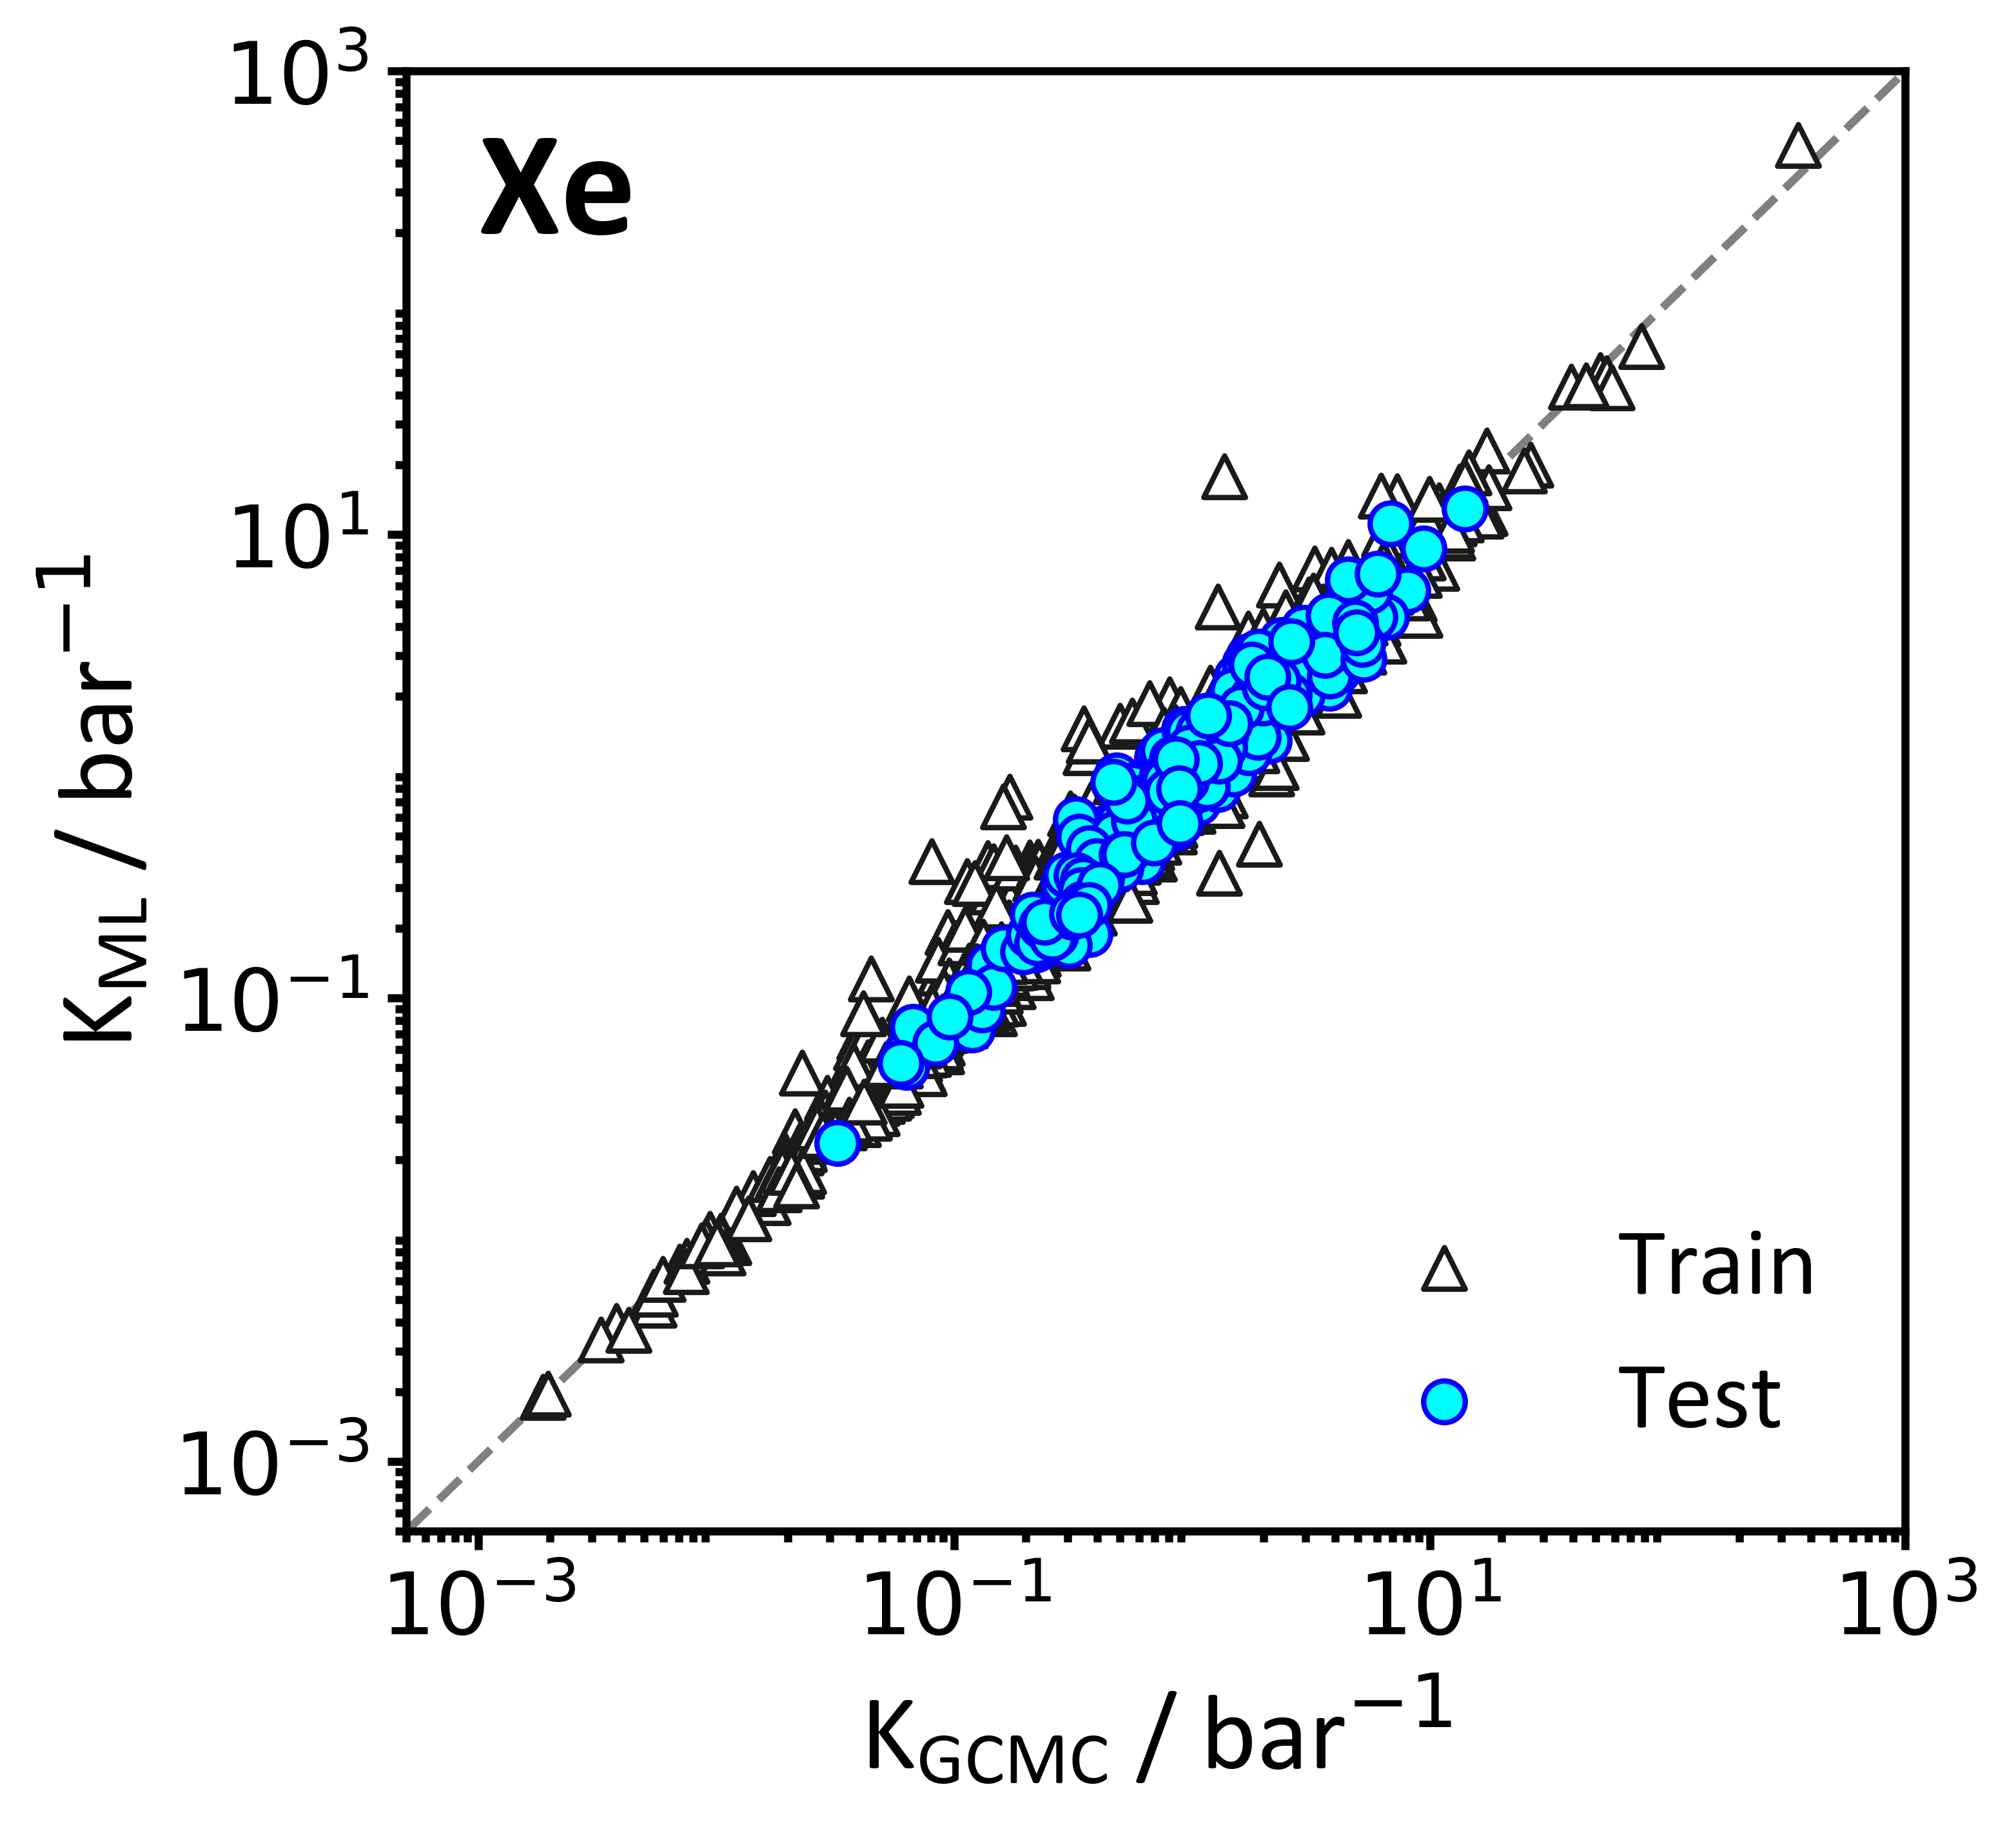

In [5]:
fig, ax = plt.subplots(figsize=(5,5),dpi=600)
ax.set_xscale('log')
ax.set_yscale('log')

x=np.linspace(0,1000)

ax.plot(x,x,'--',c="0.5",zorder=0)

ax1 = ax.scatter(data3["Xe_K_train"],data4["train_henry"]*100000/data1["Xe_M_pre"],marker='^',c="w",edgecolor='0.1',s=60,label="Train",linewidths=1)
ax2 = ax.scatter(data3["Xe_K_test"],data4["test_henry"]*100000/data2["Xe_M_pre"],marker='o',color="cyan",edgecolor='b',s=60,label="Test",linewidths=1)

x=(0.001,0.1,10,1000)

ax.set_xlim(0.0005 ,1000)
ax.set_ylim(0.0005 ,1000)

ax.legend(prop={'family':'Calibri','size':18},frameon=False,loc="lower right")

plt.xticks(x,fontsize=16)
plt.yticks(x,fontsize=16)

ax.spines['top'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)

plt.tick_params(axis='both', which='both', direction='out',width=1.5)
plt.text(0.001,200,"Xe", fontweight='bold',fontdict={'family':'Calibri','size':28})

# plt.minorticks_off()

plt.xlabel(r'$\mathregular{K_{GCMC}}$ / bar$^{-1}$',fontdict={'family':'Calibri','size':20})
plt.ylabel(r"$\mathregular{K_{ML}}$ / bar$^{-1}$",fontdict={'family':'Calibri','size':20})

plt.show()

In [97]:
R2_train=r2_score(data3["Xe_K_train"],data4["train_henry"]*100000/data1["Xe_M_pre"])
R2_test=r2_score(data3["Xe_K_test"].dropna(),data4["test_henry"].dropna()*100000/data2["Xe_M_pre"].dropna())

MAE_train=mean_absolute_error(data3["Xe_K_train"],data4["train_henry"]*100000/data1["Xe_M_pre"])
MAE_test=mean_absolute_error(data3["Xe_K_test"].dropna(),data4["test_henry"].dropna()*100000/data2["Xe_M_pre"].dropna())

RMSE_train=mean_squared_error(data3["Xe_K_train"],data4["train_henry"]*100000/data1["Xe_M_pre"],squared=False)
RMSE_test=mean_squared_error(data3["Xe_K_test"].dropna(),data4["test_henry"].dropna()*100000/data2["Xe_M_pre"].dropna(),squared=False)

print(R2_train)
print(R2_test)
print(MAE_train)
print(MAE_test)
print(RMSE_train)
print(RMSE_test)

0.885465066153044
0.8800827310222632
0.4912091477904842
0.30836045507960447
4.134985650886014
0.5777602140871879


# Get name

In [105]:
filename='name'
data_file_name=filename+".csv" # diversity selection filename
 
diverse_ratio=0.8 # training set ratio, 
remaining_ratio=1-diverse_ratio # test set ratio

In [106]:
diverse_set=[]
remaining_set=[]

txt = open("divided_set_"+str(diverse_ratio)+"_"+str("%.1f"%remaining_ratio)+"_"+"Xe-M.txt",'r').read()
print(" Load file name : divided_set_"+str(diverse_ratio)+"_"+str("%.1f"%remaining_ratio)+"_"+"Xe-M.txt")
s1=txt.find("[",0)
s2=txt.find("]",s1)
diverse_set=txt[s1+1:s2].split(", ")
diverse_set=[int(i) for i in diverse_set]
s3=txt.find("[",s2)
s4=txt.find("]",s3)
remaining_set=txt[s3+1:s4].split(", ")
remaining_set=[int(i) for i in remaining_set]
print("# of diverse set, remaining set :",len(diverse_set),len(remaining_set))


with open(data_file_name) as f:
        data_file = csv.reader(f)
        temp = next(data_file)
        N_samples = int(temp[0])
        N_features = int(temp[1])
        N_targets = int(temp[2])
        number = np.empty((N_samples,))
        structure = np.empty((N_samples,))
        data = np.empty((N_samples, N_features))
        target = np.empty((N_samples,N_targets))
        temp = next(data_file)  # names of features
        structure = []
        feature_names=temp[2:2+N_features]
        for i, d in enumerate(data_file):
            number[i] = np.asarray(d[0],dtype=np.int)
            structure.append(d[1])
            data[i] = np.asarray(d[2:2+N_features], dtype=np.float64)
            target[i] = np.asarray(d[-N_targets:], dtype=np.float64)
N_materials = data.shape[0]

diverse_set_total=[]
remaining_set_total=[]
for i,diverse in enumerate(diverse_set):
    arridx = np.where(number == diverse)
    for j,element_div in enumerate(arridx[0]):
        diverse_set_total.append(element_div)
for i,remaining in enumerate(remaining_set):
    arridx = np.where(number == remaining)
    for j,element_rem in enumerate(arridx[0]):
        remaining_set_total.append(element_rem)        

X_train = data[diverse_set_total]
y_train = target[diverse_set_total]
X_test = data[remaining_set_total]
y_test = target[remaining_set_total]

 Load file name : divided_set_0.8_0.2_Xe-M.txt
# of diverse set, remaining set : 994 249


<ipython-input-106-dd663689e4d9>:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  number[i] = np.asarray(d[0],dtype=np.int)


In [107]:
X_train_number = pd.DataFrame(X_train, columns = ["Number_train"])
X_test_number = pd.DataFrame(X_test, columns = ["Number_test"])

df_number = pd.concat([X_train_number,X_test_number],axis=1)                
df_number.to_csv('name'+'_Xe'+'.csv', header=True, index=False)

# Isotherms

In [4]:
data_name=pd.read_csv("name_Xe.csv")

In [5]:
plt.rcParams.update({'figure.max_open_warning': 0})
def langmuir(p,M,K):
    return M*K*p/(1+K*p)

In [1]:
plt.style.use('seaborn-whitegrid')
n=100
p=np.linspace(0,30,n)

for j,name in enumerate(data_name.Number_test):    
    fig,ax = plt.subplots(figsize=(5,5),dpi=600,facecolor='w')
    
    qXe1=langmuir(p,data2.Xe_M[j],data3.Xe_K_test[j])
    qXe2=langmuir(p,data2.Xe_M_pre[j],data4["test_henry"][j]*100000/data2.Xe_M_pre[j])
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    name=int(name)
    
    plt.plot(p, qXe1, '--', color='k', label='GCMC_Fit',zorder=0)
    plt.plot(p, qXe2, '--', color='b', label='ML_Pred',zorder=2)

    plt.xlabel("Pressure (bar)")
    plt.title(name)

    plt.xlim([0, 31])
    plt.ylabel("Uptake (mmol/g)")
    plt.legend(loc='lower right')
    plt.savefig('./Test/'+str(name)+'_Xe.jpg',dpi=300)

NameError: name 'plt' is not defined